In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def make_data(n_pos, n_neg, max_samples=10000, seed=11):
    import torch
    assert n_pos <= max_samples
    assert n_neg <= max_samples
    
    torch.manual_seed(seed)

    # https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/11
    #X = torch.fmod(torch.randn(max_samples, 2),2) + torch.tensor([-3., 3.])
    X = torch.randn(max_samples, 2) + torch.tensor([-1., 1.])
    
    pos_idx = torch.randperm(max_samples)[:n_pos]
    neg_idx = torch.randperm(max_samples)[:n_neg]
    
    X_pos = X[pos_idx]
    X_neg = X[neg_idx] # reflect over the line `y = x`
    X_neg = X_neg[:, [1, 0]]
    
    
    y_pos = torch.ones(n_pos, dtype=torch.long)
    y_neg = torch.zeros(n_neg, dtype=torch.long)
    
    return X_pos.numpy(), y_pos.numpy(), X_neg.numpy(), y_neg.numpy()

In [3]:
X_pos, y_pos, X_neg, y_neg = make_data(200, 40)
X = np.concatenate([X_pos, X_neg])
y = np.concatenate([y_pos, y_neg])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)

weights = class_weights[y]

In [4]:
def resampling_schedule(X, y, weights, tradeoff_fn, T):
    # Can also just return the keep_idx from each t.
    weights = weights / np.max(weights)
    for t in range(T + 1):
        rv = np.random.rand(*weights.shape)

        keep_idx = (rv <= tradeoff_fn(weights, t, T))

        #X_t = X[keep_idx]
        #y_t = y[keep_idx]
        weights_t = weights[keep_idx] / tradeoff_fn(weights[keep_idx], t, T)

        #yield X_t, y_t, weights_t
        yield keep_idx, weights_t

In [120]:
def g(weights, t, T, anneal_fn="linear"):
    if anneal_fn == "linear":
        beta = t / T
    elif anneal_fn == "sigmoid":
        x = t / T
        beta = 1 / (1 + np.exp(-15 * (x - 0.5)))  # shifted sigmoid
    return weights ** (1 - beta)

T = 25

keep_idxs, weights_ts = zip(*list(resampling_schedule(X, y, weights, g, T)))

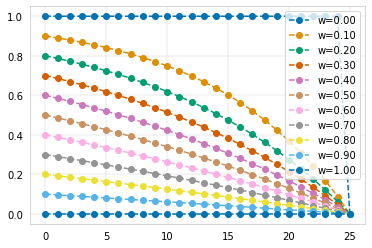

In [130]:
t = np.arange(T + 1)
for w in np.linspace(0., 1., 11):
    g_t = [1 - g(w, t_, T, "linear") for t_ in t]
    plt.plot(t, g_t, '--o', label=f"{w=:.2f}")
    plt.legend()

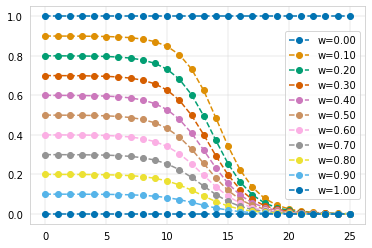

In [129]:
t = np.arange(T + 1)
for w in np.linspace(0., 1., 11):
    g_t = [1 - g(w, t_, T, "sigmoid") for t_ in t]
    plt.plot(t, g_t, '--o', label=f"{w=:.2f}")
    plt.legend()

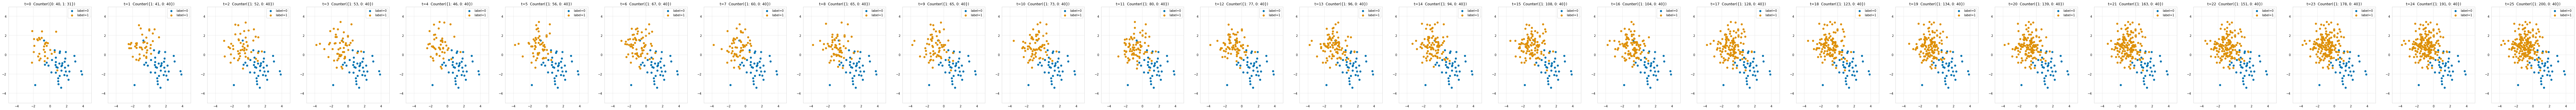

In [126]:
from collections import Counter
fig, axes = plt.subplots(ncols=T + 1, figsize=(6* (T+1), 6))
for t, keep_idx in enumerate(keep_idxs):
    ax = axes[t]
    X_ = X[keep_idx]
    y_ = y[keep_idx]
    for label in np.unique(y):
        idx = y_ == label
        ax.scatter(*X_[idx].T, label=f"{label=}")
    ax.legend()
    ax.set(title=f"{t=}  {Counter(y_)}", xlim=(-5, 5), ylim=(-5,5))